In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
transform = transforms.ToTensor()
batch_size = 8

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('T-shirt/top', 'Trouser/pants','Pullover shirt','Dress','Coat','Sandal',
           'Shirt','Sneaker','Bag','Ankle boot')

100%|██████████| 26.4M/26.4M [00:08<00:00, 2.98MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 106kB/s]
100%|██████████| 4.42M/4.42M [00:05<00:00, 776kB/s] 
100%|██████████| 5.15k/5.15k [00:00<00:00, 49.6MB/s]


In [4]:
trainset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
train_iter = iter(trainset)
image, label = next(train_iter)

image.shape, label

(torch.Size([1, 28, 28]), 9)

In [ ]:
torch.min(image).item(), torch.max(image).item() # values(range) on image matrix

(0.0, 1.0)

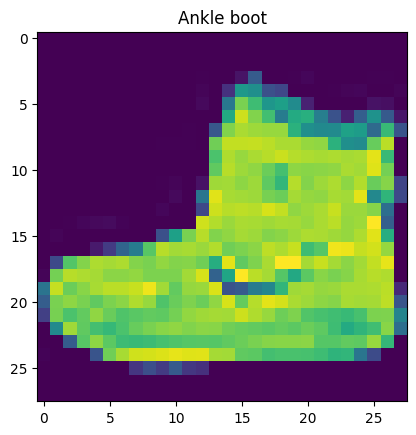

In [8]:
import matplotlib.pyplot as plt
import numpy as np

np_img = image.numpy()
plt.title(classes[label])
plt.imshow(np_img.reshape((28, 28, 1)))

In [9]:
len(trainset), len(testset)

(60000, 10000)

In [10]:
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])
len(trainset), len(valset), len(testset)

(50000, 10000, 10000)

In [11]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=2)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features=4096, out_features=1024)
        self.drop1 = nn.Dropout(p=0.3)

        self.fc2 = nn.Linear(in_features=1024, out_features=1024)
        self.drop2 = nn.Dropout(p=0.3)
        
        self.out = nn.Linear(in_features=1024, out_features=10)

    
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = self.pool1(x)

      x = F.relu(self.conv2(x))
      x = self.pool2(x)

      x = F.relu(self.conv3(x))
      x = self.pool3(x)

      x = self.flatten(x)

      x = F.relu(self.fc1(x))
      x = self.drop1(x)

      x = F.relu(self.fc2(x))
      x = self.drop2(x)

      x = self.out(x)

      return x

In [13]:
net = NeuralNet()
net.to(device)

NeuralNet(
  (conv1): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(512, 1024, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (drop2): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=1024, out_features=10, bias=True)
)

In [14]:
for i, data in enumerate(trainloader):
    inputs, labels = data[0].to(device), data[1].to(device)
    print(f'input shape: {inputs.shape}')
    print(f'after network shape: {net(inputs).shape}')
    break

input shape: torch.Size([8, 1, 28, 28])
after network shape: torch.Size([8, 10])


In [15]:
num_params = 0
for x in net.parameters():
  num_params += len(torch.flatten(x))

print(f'Number of parameters in the model: {num_params:,}')

Number of parameters in the model: 8,536,074


In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [17]:
def train_one_epoch():
  net.train(True)

  running_loss = 0.0
  running_accuracy = 0.0

  for batch_index, data in enumerate(trainloader):
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()

    outputs = net(inputs) # shape: [batch_size, 10]
    correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
    running_accuracy += correct / batch_size

    loss = criterion(outputs, labels)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()

    if batch_index % 500 == 499:  # print every 500 batches
      avg_loss_across_batches = running_loss / 500
      avg_acc_across_batches = (running_accuracy / 500) * 100
      print('Batch {0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_index+1,
                                                          avg_loss_across_batches,
                                                          avg_acc_across_batches))
      running_loss = 0.0
      running_accuracy = 0.0

    
  print()

In [18]:
def validate_one_epoch():
    net.train(False)
    running_loss = 0.0
    running_accuracy = 0.0
    
    for i, data in enumerate(valloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        with torch.no_grad():
            outputs = net(inputs) # shape: [batch_size, 10]
            correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += correct / batch_size
            loss = criterion(outputs, labels) # One number, the average batch loss
            running_loss += loss.item()
        
    avg_loss_across_batches = running_loss / len(valloader)
    avg_acc_across_batches = (running_accuracy / len(valloader)) * 100
    
    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches,
                                                            avg_acc_across_batches))
    print('***************************************************')
    print()

In [19]:
num_epochs = 5

for epoch_index in range(num_epochs):
    print(f'Epoch: {epoch_index + 1}\n')
    
    train_one_epoch()
    validate_one_epoch()
        

print('Finished Training')

Epoch: 1

Batch 500, Loss: 1.181, Accuracy: 55.1%
Batch 1000, Loss: 0.737, Accuracy: 72.0%
Batch 1500, Loss: 0.641, Accuracy: 76.0%
Batch 2000, Loss: 0.587, Accuracy: 77.7%
Batch 2500, Loss: 0.578, Accuracy: 79.1%
Batch 3000, Loss: 0.543, Accuracy: 79.4%
Batch 3500, Loss: 0.503, Accuracy: 81.4%
Batch 4000, Loss: 0.474, Accuracy: 82.8%
Batch 4500, Loss: 0.456, Accuracy: 83.9%
Batch 5000, Loss: 0.448, Accuracy: 82.8%
Batch 5500, Loss: 0.442, Accuracy: 83.5%
Batch 6000, Loss: 0.431, Accuracy: 84.2%

Val Loss: 0.382, Val Accuracy: 85.8%
***************************************************

Epoch: 2

Batch 500, Loss: 0.375, Accuracy: 86.3%
Batch 1000, Loss: 0.366, Accuracy: 86.7%
Batch 1500, Loss: 0.363, Accuracy: 86.6%
Batch 2000, Loss: 0.359, Accuracy: 86.7%
Batch 2500, Loss: 0.370, Accuracy: 86.1%
Batch 3000, Loss: 0.388, Accuracy: 86.1%
Batch 3500, Loss: 0.346, Accuracy: 87.2%
Batch 4000, Loss: 0.359, Accuracy: 86.8%
Batch 4500, Loss: 0.335, Accuracy: 87.8%
Batch 5000, Loss: 0.340, Accur